In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [6]:
import numpy as np
import pandas as pd
from collections import Counter

# -------------------------
# Implementação da Árvore
# -------------------------
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, n_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.tree = None

    def fit(self, X, y):
        self.n_classes = len(set(y))
        self.n_features = X.shape[1] if not self.n_features else self.n_features
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if (depth >= self.max_depth or num_labels == 1 or num_samples < self.min_samples_split):
            return Counter(y).most_common(1)[0][0]

        feat_idxs = np.random.choice(num_features, self.n_features, replace=False)

        # Melhor split
        best_feat, best_thresh = self._best_split(X, y, feat_idxs)
        if best_feat is None:
            return Counter(y).most_common(1)[0][0]

        # Splitar dados
        indices_left = X[:, best_feat] <= best_thresh
        X_left, y_left = X[indices_left], y[indices_left]
        X_right, y_right = X[~indices_left], y[~indices_left]

        left_child = self._grow_tree(X_left, y_left, depth + 1)
        right_child = self._grow_tree(X_right, y_right, depth + 1)
        return (best_feat, best_thresh, left_child, right_child)

    def _best_split(self, X, y, feat_idxs):
        best_gini = 1.0
        best_idx, best_thresh = None, None

        for idx in feat_idxs:
            thresholds = np.unique(X[:, idx])
            for thr in thresholds:
                gini = self._gini_index(y, X[:, idx], thr)
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thresh = thr
        return best_idx, best_thresh

    def _gini_index(self, y, feature_values, threshold):
        left_mask = feature_values <= threshold
        right_mask = ~left_mask
        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return 1.0

        def gini_group(labels):
            m = len(labels)
            counts = np.bincount(labels)
            return 1.0 - sum((count / m) ** 2 for count in counts if count > 0)

        left_gini = gini_group(y[left_mask])
        right_gini = gini_group(y[right_mask])
        m = len(y)
        return (np.sum(left_mask) / m) * left_gini + (np.sum(right_mask) / m) * right_gini

    def predict(self, X):
        return np.array([self._predict(inputs, self.tree) for inputs in X])

    def _predict(self, inputs, tree):
        if not isinstance(tree, tuple):
            return tree
        feat_idx, threshold, left_child, right_child = tree
        if inputs[feat_idx] <= threshold:
            return self._predict(inputs, left_child)
        else:
            return self._predict(inputs, right_child)

# -------------------------
# Implementação do Random Forest
# -------------------------
class OurRandomForest:
    def __init__(self, n_trees=10, max_depth=None, min_samples_split=2, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                                min_samples_split=self.min_samples_split,
                                n_features=self.n_features)
            # Bootstrap sample
            idxs = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[idxs], y[idxs]
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Votação majoritária
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        return np.array([Counter(preds).most_common(1)[0][0] for preds in tree_preds])

# -------------------------
# Exemplo de uso
# -------------------------

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

data = load_iris()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = OurRandomForest(n_trees=10, max_depth=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = np.mean(y_pred == y_test)
print(f"Acurácia: {acc:.4f}")


Acurácia: 1.0000


In [9]:
from sklearn.ensemble import RandomForestClassifier
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=10, max_depth=5, max_features=None)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = np.mean(y_pred == y_test)
print(f"Acurácia: {acc:.4f}")


Acurácia: 1.0000


In [14]:
import time
### A function to benchmark a implementation of rf:
def benchmark_rf(clf, X, y, n_tests=5, test_size=0.3):
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    accuracies = []
    train_times = []
    test_times = []
    for i in range(n_tests):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        model = clf
        
        ### Training
        start = time.time()
        model.fit(X_train, y_train)
        train_times.append(time.time() - start)
        
        ### Testing
        start = time.time()
        y_pred = model.predict(X_test)
        test_times.append(time.time() - start)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        
    
    return pd.DataFrame({
        'implementation': [clf.__class__.__name__]*n_tests,
        'n_features': [X.shape[1]]*n_tests,
        'n_samples': [X.shape[0]]*n_tests,
        'seed': list(range(n_tests)),
        'accuracy': accuracies,
        'train_time': train_times,
        'test_time': test_times})

In [30]:
from tqdm import trange
from sklearn.datasets import make_classification

results = pd.DataFrame()

for i in trange(10,100, 10):
    # Create syntetic dataset using scikit with i features and 500 samples
    data = make_classification(n_samples=100, n_features=i, n_informative=int(i*0.6), n_redundant=int(i*0.2), n_clusters_per_class=2, random_state=42)
    X, y = data
    results = pd.concat([pd.concat([benchmark_rf(OurRandomForest(n_trees=100, max_depth=10), X, y),
    benchmark_rf(RandomForestClassifier(n_estimators=100, max_depth=10, max_features=None, criterion='entropy'), X, y)]), results], ignore_index=True)


100%|██████████| 9/9 [14:33<00:00, 97.06s/it] 


In [33]:
results.to_csv('results/results.csv', index=False)

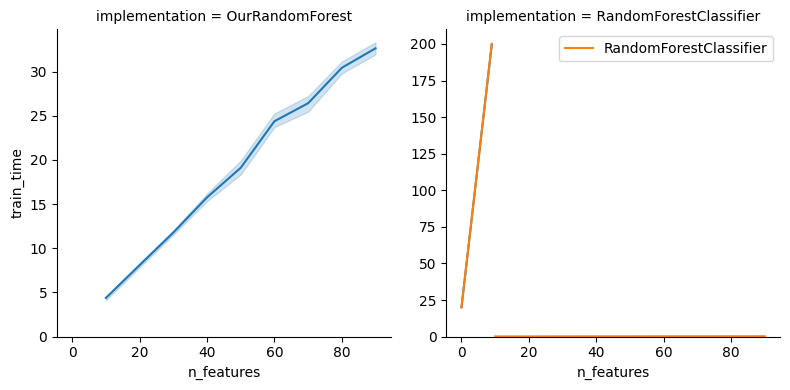

In [ ]:
import seaborn as sns

g = sns.FacetGrid(data = results, col='implementation', sharey=False, height=4, hue='implementation')
g.map(sns.lineplot, 'n_features', "train_time")

# Ensure each facet's y-axis starts at 0
for ax in g.axes.flatten():
    ax.set_ylim(bottom=0)

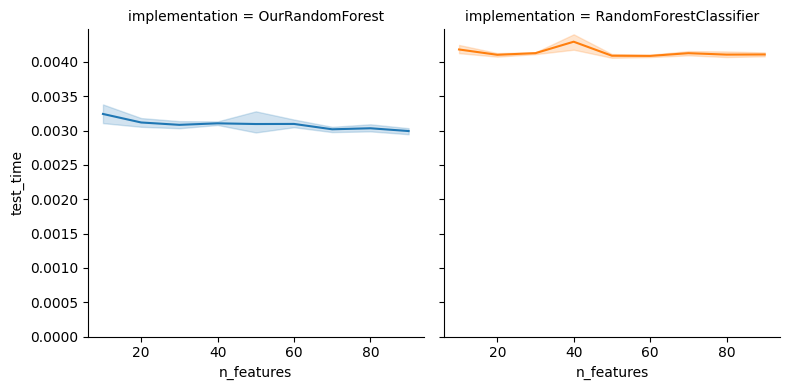

In [ ]:
import seaborn as sns

g = sns.FacetGrid(data = results, col='implementation', sharey=True, height=4, hue='implementation')
g.map(sns.lineplot, 'n_features',"test_time")

for ax in g.axes.flatten():
    ax.set_ylim(bottom=0.0)

<Axes: >

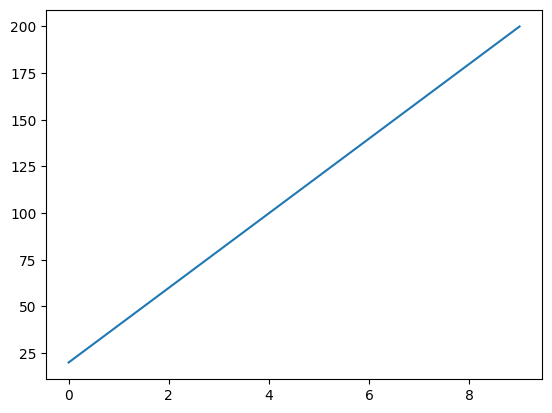

In [54]:
sns.lineplot([20 +20*i for i in range(10)])